# Demo: Simple two photo difference.

An initial demonstration from just two photos illustrating 50mm^2 retroreflectors 100m away.

can't open model file c:\Users\cs1sch\Documents\retrodetect\venv\Lib\site-packages\retrodetect/beetrack.model


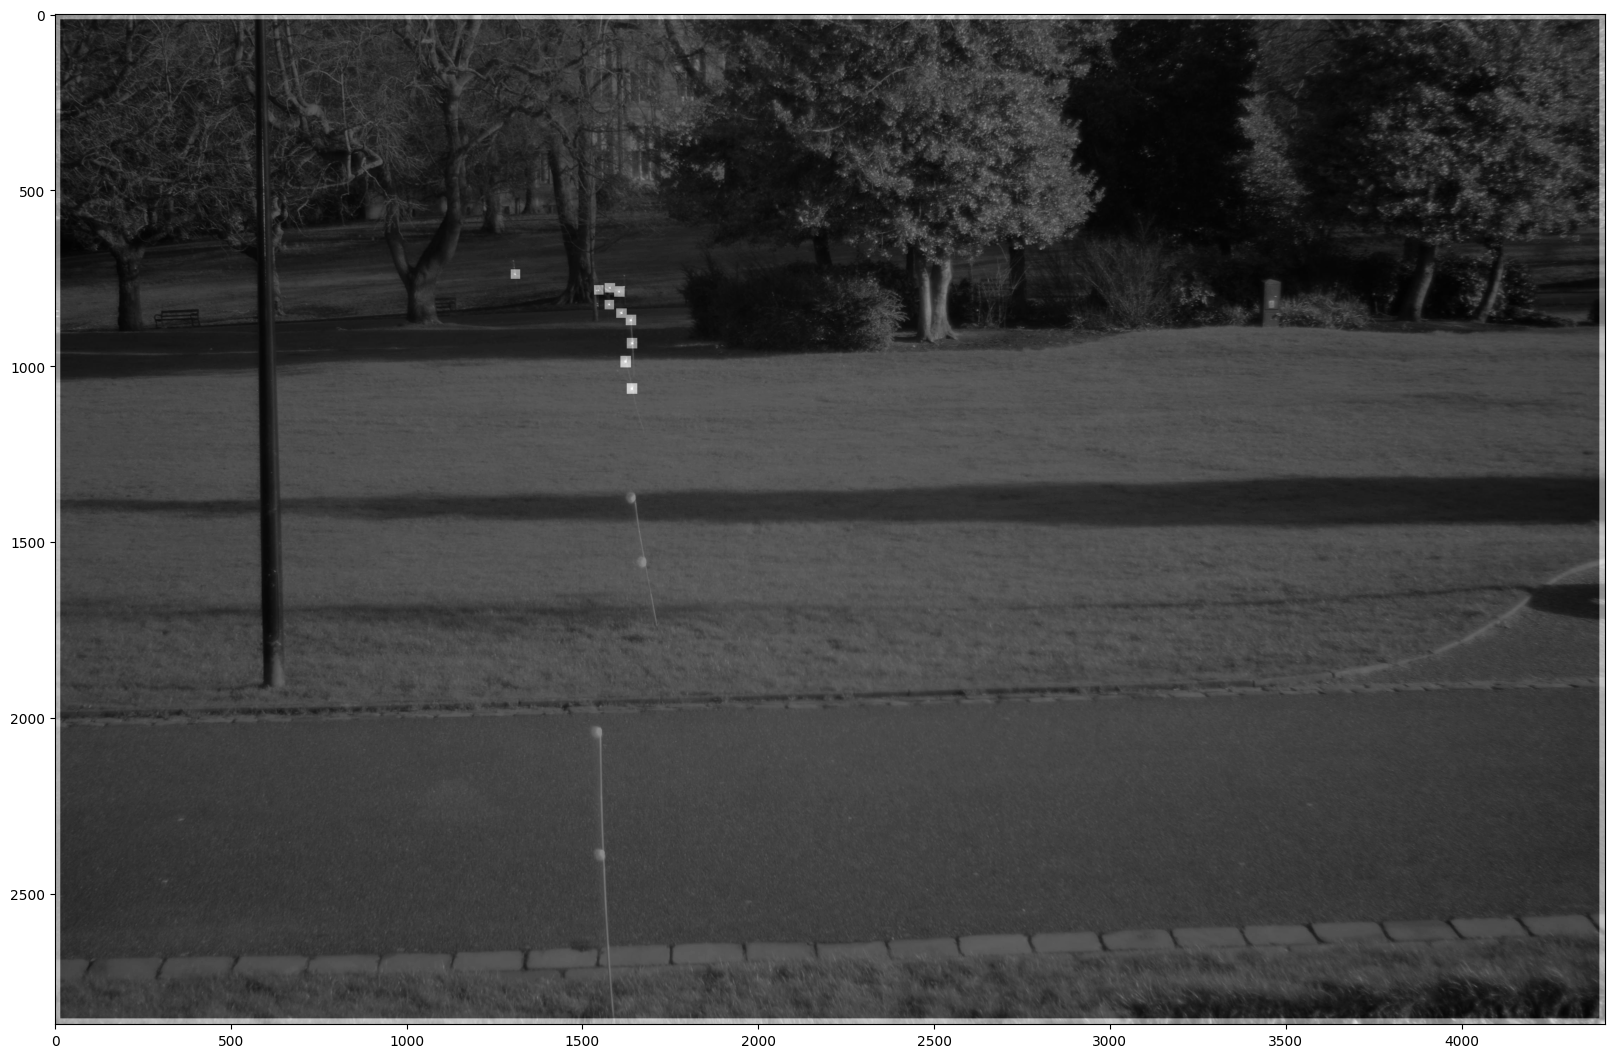

In [6]:
import retrodetect as rd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2 #note: cv2 needed for this demo

flash = cv2.imread('flash1.jpg',0).astype(float)
noflash = cv2.imread('noflash1.jpg',0).astype(float)

done = rd.detect(flash,noflash,blocksize=20, offset=10, searchbox=20, step=4, searchblocksize=50, ensemblesizesqrt=3, dilate=True,margin=100)
#the above, function does three things...
#shift = rd.getshift(flash,noflash)
#out_img = rd.getblockmaxedimage(noflash,5,5)
#done = rd.alignandsubtract(out_img,shift,flash)

plt.figure(figsize=[20,20])
foundimg = 20*(rd.getblockmaxedimage(done,3,5)>40)
plt.imshow(flash[100:-100,100:-100]*0.1+foundimg,cmap='gray')
#the low res image version can't see the distant reflectors

# Demo: Full System

This example illustrates the system working on a list of images.

In [ ]:
!unzip demo.zip

The key line is:

        detectcontact(photo_list,n,delsize=100)
        
here we pass a list of photo objects, and ask it to find the reflector in the nth image in that list.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from retrodetect import detectcontact
#from QueueBuffer import QueueBuffer
from glob import glob
import pickle
import pandas as pd
df = pd.read_csv('labels_photos_June08.csv',names=['index','filename','x','y'])
import pickle

correctx = None
correcty = None
photo_list = []
for imfilename in sorted(glob('photo_object*.np')):
    photoitem = pickle.load(open(imfilename,'rb'))
    def getname(x):
        return x.split('/')[-1]
    dfs=df[df['filename'].apply(getname)==imfilename.split('/')[-1]]
    if len(dfs)>0: 
        correctx = dfs['x'].tolist()[0]
        correcty = dfs['y'].tolist()[0]
    
    if photoitem is not None:
        if photoitem['img'] is not None:
            photoitem['img'] = photoitem['img'].astype(np.float32)
        photoitem['correctx']=correctx
        photoitem['correcty']=correcty
    if len(dfs)==0:
        correctx=None
        correcty=None
    photo_list.append(photoitem)
    
def drawreticule(x,y,c='w',alpha=0.5,angle=False):
    if angle:
        plt.plot([x-70,x-10],[y-70,y-10],c,alpha=alpha)
        plt.plot([x+70,x+10],[y+70,y+10],c,alpha=alpha)
        plt.plot([x-70,x-10],[y+70,y+10],c,alpha=alpha)
        plt.plot([x+70,x+10],[y-70,y-10],c,alpha=alpha)
    else:
        plt.hlines(y,x-70,x-10,c,alpha=alpha)
        plt.hlines(y,x+10,x+70,c,alpha=alpha)
        plt.vlines(x,y-70,y-10,c,alpha=alpha)
        plt.vlines(x,y+10,y+70,c,alpha=alpha)

for n in range(len(photo_list)):
    if not photo_list[n]['record']['endofset']: continue
    contact,found,searchimg = detectcontact(photo_list,n,delsize=100)
    
    if contact is None: continue
    if photo_list[n]['correctx'] is None: continue #we don't know where it is in the photo

    plt.figure(figsize=[25,20])
    img = photo_list[n-1]['img']
    plt.imshow(img)
    plt.clim([0,10])
    plt.colorbar()
    for c in contact:
        drawreticule(c['x'],c['y'])
        drawreticule(photo_list[n]['correctx'],photo_list[n]['correcty'],'y',1,angle=True)
        plt.title([photo_list[n]['index'],c['x'],c['y']])
        if c['prediction']<0:
            plt.gca().add_artist(plt.Circle((c['x'],c['y']), 50, color='w',fill=False))

The white + crosses are the ten candidate maximum locations.
The yellow x cross indicates the true location of the retroreflector.
The white circle indicates the locations where the confidence threshold has been met.